## Plot throughput for different write buffer implementations

In [1]:
# ! pip install pandas matplotlib

In [2]:
from typing import List, Dict, Tuple

import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

__WORKING_BRANCH_PATH = (
    "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch"
)

hatch = {
    'Vector': '',
    'Skiplist': '\\\\\\\\\\\\',
    'Hashskiplist': '//',
    'Hashlinklist': '----'
}

linestyle = {
    'Vector': '-',
    'Skiplist': '-',
    'Hashskiplist': '-.',
    'Hashlinklist': '..'
}

alpha = {
    'Vector': 1,
    'Skiplist': 0.8,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

color = {
    'Vector': 'darkslateblue',
    'Skiplist': 'slategray',
    'Hashskiplist': 'darkkhaki',
    'Hashlinklist': 'chocolate'
    # 'Vector': 'black',
    # 'Skiplist': 'black',
    # 'Hashskiplist': 'black',
    # 'Hashlinklist': 'black'
}

linewidth = {
    'Vector': 1,
    'Skiplist': 1,
    'Hashskiplist': 1,
    'Hashlinklist': 1,
}

edgecolor = {
    'Vector': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black'
}

label = {
    'Vector': 'vector',
    'Skiplist': 'skiplist',
    'Hashskiplist': 'hash skiplist',
    'Hashlinklist': 'hash linklist'
}

plt.rcParams["font.family"] = "serif"

alphabets = "abcdefghijklmnopqrstuvwxyz"

In [3]:
def get_properties(key: str) -> Dict[str, str]:
    if key.capitalize() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": color.get(key.capitalize()) or "None",
            # "edgecolor": edgecolor.get(key.capitalize()) or "None",
            # "linestyle": linestyle.get(key.capitalize()),
            "hatch": hatch.get(key.capitalize()),
            "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")

In [4]:
def get_exp_dirname(query_type: str, selectivity: float, entry_size: int, epp: int) -> str:
    return (
        f"{__WORKING_BRANCH_PATH}/experiments-{query_type}-{selectivity}-{entry_size}-{epp}"
    )


def get_log_file_path(
    query_type: str,
    inserts: int,
    point_queries: int,
    range_queries: int,
    selectivity: float,
    memtable: str,
    entry_size: int,
    number_of_entries_per_page: int,
    number_of_pages: int,
    prefixlen: int = 0,
    bucket_count: int = 0,
    size_ratio: int = 4,
    updates: int = 0,
):
    if memtable.lower() in ("hashskiplist", "hashlinklist"):
        return f"{get_exp_dirname(query_type, selectivity, entry_size, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio} l {prefixlen} bucket_count {bucket_count}"
    return f"{get_exp_dirname(query_type, selectivity, entry_size, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio}"

In [5]:
keys = {
    "InsertTime: ": "Total time taken by inserts = ",
    "PointQueryTime: ": "Total time taken by queries = ",
    "RangeQueryTime: ": "Total time taken by range queries = ",
}

def prepare_dataframe(log_file_path: str, loopupkeys: List[str]=[]) -> float:
    ff = open(log_file_path, "r")
    total_time = 0
    total_operations = 0

    for line in ff.readlines():
        if any([key in line for key in loopupkeys]):
            total_operations += 1
    
    ff.close()
    ff = open(log_file_path, "r")

    for line in ff.readlines():
        if "Total time taken by workload = " in line:
            print(">>>>>>>>>>>>>>>", line)
            total_time = float(line.split(" = ")[1].split(" ")[0])
            break
    
    # print(key, "\n", keys[key], "\n", total_operations, "\n", total_time, "\n", log_file_path)
    return total_operations / total_time


In [6]:
entry_size = 64
memtables = ["Vector", "Skiplist", "HashSkiplist", "HashLinklist"]
inserts = 120000
point_queries = 0 # (10 % point queries)
range_queries = 0
number_of_entries_per_page = 64
number_of_pages = 4096
updates = 0
prefixlen = 4
bucket_count = 100000

selectivity = 0

## Only inserts

In [7]:
only_inserts = "Only-Inserts-Vec-Def"


vec_log_file = get_log_file_path(
    only_inserts,
    120000,
    0,
    0,
    0,
    memtables[0],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

vect_inserts = prepare_dataframe(vec_log_file + "/workload.log", loopupkeys=["InsertTime: "])

skip_log_file = get_log_file_path(
    only_inserts,
    120000,
    0,
    0,
    0,
    memtables[1],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

skip_inserts = prepare_dataframe(skip_log_file + "/workload.log", loopupkeys=["InsertTime: "])

hash_skip_log_file = get_log_file_path(
    only_inserts,
    120000,
    0,
    0,
    0,
    memtables[2],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

hash_skip_inserts = prepare_dataframe(hash_skip_log_file + "/workload.log", loopupkeys=["InsertTime: "])

hash_link_log_file = get_log_file_path(
    only_inserts,
    120000,
    0,
    0,
    0,
    memtables[3],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

hash_link_inserts = prepare_dataframe(hash_link_log_file + "/workload.log", loopupkeys=["InsertTime: "])


>>>>>>>>>>>>>>> Total time taken by workload = 9623655059 ns

>>>>>>>>>>>>>>> Total time taken by workload = 9624636073 ns

>>>>>>>>>>>>>>> Total time taken by workload = 9624411732 ns

>>>>>>>>>>>>>>> Total time taken by workload = 9625048917 ns



## Vector Preallocated

In [20]:
only_inserts = "Only-Inserts-Vec-Pre"


vec_log_file = get_log_file_path(
    only_inserts,
    120000,
    0,
    0,
    0,
    memtables[0],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

vector_pre_allocated = prepare_dataframe(vec_log_file + "/workload.log", loopupkeys=["InsertTime: "])

only_inserts = "Nearly-Full-Vec-Pre"

vec_log_file = get_log_file_path(
    only_inserts,
    120000,
    2400,
    0,
    0,
    memtables[0],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

vect_nearly_full_inserts_pre_allocated = prepare_dataframe(vec_log_file + "/workload.log", loopupkeys=["InsertTime: ", "PointQueryTime: "])

only_inserts = "Interleaved-PQ-Vec-Pre"

vec_log_file = get_log_file_path(
    only_inserts,
    120000,
    2400,
    0,
    0,
    memtables[0],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

vect_interleaved_inserts_pre_allocated = prepare_dataframe(vec_log_file + "/workload.log", loopupkeys=["InsertTime: ", "PointQueryTime: "])

only_inserts = "RQ-small-Vec-Pre"

vec_log_file = get_log_file_path(
    only_inserts,
    120000,
    0,
    2400,
    0.0001,
    memtables[0],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

vect_small_inserts_pre_allocated = prepare_dataframe(vec_log_file + "/workload.log", loopupkeys=["InsertTime: ", "RangeQueryTime: "])

>>>>>>>>>>>>>>> Total time taken by workload = 9623165382 ns

>>>>>>>>>>>>>>> Total time taken by workload = 83912016493 ns

>>>>>>>>>>>>>>> Total time taken by workload = 46296606723 ns

>>>>>>>>>>>>>>> Total time taken by workload = 84466818864 ns



In [8]:
vect_inserts

1.2469378761427613e-05

## Nearly Full

In [9]:
only_inserts = "Nearly-Full"


vec_log_file = get_log_file_path(
    only_inserts,
    120000,
    2400,
    0,
    0,
    memtables[0],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

vect_nearly_full_inserts = prepare_dataframe(vec_log_file + "/workload.log", loopupkeys=["InsertTime: ", "PointQueryTime: "])
# vec_nearly_full_pq = prepare_dataframe(vec_log_file + "/workload.log", key=)

skip_log_file = get_log_file_path(
    only_inserts,
    120000,
    2400,
    0,
    0,
    memtables[1],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

skip_nearly_full_inserts = prepare_dataframe(skip_log_file + "/workload.log", loopupkeys=["InsertTime: ", "PointQueryTime: "])
# skip_nearly_full_pq = prepare_dataframe(skip_log_file + "/workload.log", key="PointQueryTime: ")

hash_skip_log_file = get_log_file_path(
    only_inserts,
    120000,
    2400,
    0,
    0,
    memtables[2],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

hash_skip_nearly_full_inserts = prepare_dataframe(hash_skip_log_file + "/workload.log", loopupkeys=["InsertTime: ", "PointQueryTime: "])
# hash_skip_nearly_full_pq = prepare_dataframe(hash_skip_log_file + "/workload.log", key="PointQueryTime: ")

hash_link_log_file = get_log_file_path(
    only_inserts,
    120000,
    2400,
    0,
    0,
    memtables[3],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

hash_link_nearly_full_inserts = prepare_dataframe(hash_link_log_file + "/workload.log", loopupkeys=["InsertTime: ", "PointQueryTime: "])
# hash_link_nearly_full_pq = prepare_dataframe(hash_link_log_file + "/workload.log", key="PointQueryTime: ")


>>>>>>>>>>>>>>> Total time taken by workload = 83081516925 ns

>>>>>>>>>>>>>>> Total time taken by workload = 9625903770 ns

>>>>>>>>>>>>>>> Total time taken by workload = 9626006388 ns

>>>>>>>>>>>>>>> Total time taken by workload = 9625706214 ns



## Interleaved PQ

In [10]:
only_inserts = "Interleaved-PQ"


vec_log_file = get_log_file_path(
    only_inserts,
    120000,
    2400,
    0,
    0,
    memtables[0],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

vect_interleaved_inserts = prepare_dataframe(vec_log_file + "/workload.log", loopupkeys=["InsertTime: ", "PointQueryTime: "])
# vec_interleaved_pq = prepare_dataframe(vec_log_file + "/workload.log", key="PointQueryTime: ")

skip_log_file = get_log_file_path(
    only_inserts,
    120000,
    2400,
    0,
    0,
    memtables[1],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

skip_interleaved_inserts = prepare_dataframe(skip_log_file + "/workload.log", loopupkeys=["InsertTime: ", "PointQueryTime: "])
# skip_interleaved_pq = prepare_dataframe(skip_log_file + "/workload.log", key="PointQueryTime: ")

hash_skip_log_file = get_log_file_path(
    only_inserts,
    120000,
    2400,
    0,
    0,
    memtables[2],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

hash_skip_interleaved_inserts = prepare_dataframe(hash_skip_log_file + "/workload.log", loopupkeys=["InsertTime: ", "PointQueryTime: "])
# hash_skip_interleaved_pq = prepare_dataframe(hash_skip_log_file + "/workload.log", key="PointQueryTime: ")

hash_link_log_file = get_log_file_path(
    only_inserts,
    120000,
    2400,
    0,
    0,
    memtables[3],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

hash_link_interleaved_inserts = prepare_dataframe(hash_link_log_file + "/workload.log", loopupkeys=["InsertTime: ", "PointQueryTime: "])
# hash_link_interleaved_pq = prepare_dataframe(hash_link_log_file + "/workload.log", key="PointQueryTime: ")


>>>>>>>>>>>>>>> Total time taken by workload = 46495755602 ns

>>>>>>>>>>>>>>> Total time taken by workload = 9623069835 ns

>>>>>>>>>>>>>>> Total time taken by workload = 9625107978 ns

>>>>>>>>>>>>>>> Total time taken by workload = 9625444608 ns



## Small Range Query

In [11]:
only_inserts = "RQ-small"


vec_log_file = get_log_file_path(
    only_inserts,
    120000,
    0,
    2400,
    0.0001,
    memtables[0],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

vect_small_inserts = prepare_dataframe(vec_log_file + "/workload.log", loopupkeys=["InsertTime: ", "RangeQueryTime: "])
# vec_small_ranges = prepare_dataframe(vec_log_file + "/workload.log", key="RangeQueryTime: ")

skip_log_file = get_log_file_path(
    only_inserts,
    120000,
    0,
    2400,
    0.0001,
    memtables[1],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

skip_small_inserts = prepare_dataframe(skip_log_file + "/workload.log", loopupkeys=["InsertTime: ", "RangeQueryTime: "])
# skip_small_ranges = prepare_dataframe(skip_log_file + "/workload.log", key="RangeQueryTime: ")

hash_skip_log_file = get_log_file_path(
    only_inserts,
    120000,
    0,
    2400,
    0.0001,
    memtables[2],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

hash_skip_small_inserts = prepare_dataframe(hash_skip_log_file + "/workload.log", loopupkeys=["InsertTime: ", "RangeQueryTime: "])
# hash_skip_small_ranges = prepare_dataframe(hash_skip_log_file + "/workload.log", key="RangeQueryTime: ")

hash_link_log_file = get_log_file_path(
    only_inserts,
    120000,
    0,
    2400,
    0.0001,
    memtables[3],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen=prefixlen,
    bucket_count=bucket_count,
    size_ratio=4,
    updates=updates,
)

hash_link_small_inserts = prepare_dataframe(hash_link_log_file + "/workload.log", loopupkeys=["InsertTime: ", "RangeQueryTime: "])
# hash_link_small_ranges = prepare_dataframe(hash_link_log_file + "/workload.log", key="RangeQueryTime: ")


>>>>>>>>>>>>>>> Total time taken by workload = 84111276028 ns



>>>>>>>>>>>>>>> Total time taken by workload = 9628480486 ns

>>>>>>>>>>>>>>> Total time taken by workload = 40181913593 ns

>>>>>>>>>>>>>>> Total time taken by workload = 36745261279 ns



In [12]:
# def get_throughtput(data: List[float], timetaken: float) -> float:
#     return len(data) / timetaken

In [13]:
[vect_inserts, vector_pre_allocated, skip_inserts, hash_skip_inserts, hash_link_inserts]

[1.2469378761427613e-05,
 1.2468107790240392e-05,
 1.2468398416602571e-05,
 1.2467572999868215e-05]

In [14]:
[vect_nearly_full_inserts, skip_nearly_full_inserts, hash_skip_nearly_full_inserts, hash_link_nearly_full_inserts]

[1.4732639042988924e-06,
 1.2715793023141764e-05,
 1.2715657466484532e-05,
 1.2716053999443204e-05]

In [15]:
[vect_interleaved_inserts, skip_interleaved_inserts, hash_skip_interleaved_inserts, hash_link_interleaved_inserts]

[2.632519859398413e-06,
 1.2719537746137536e-05,
 1.2716844349151259e-05,
 1.2716399603844668e-05]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


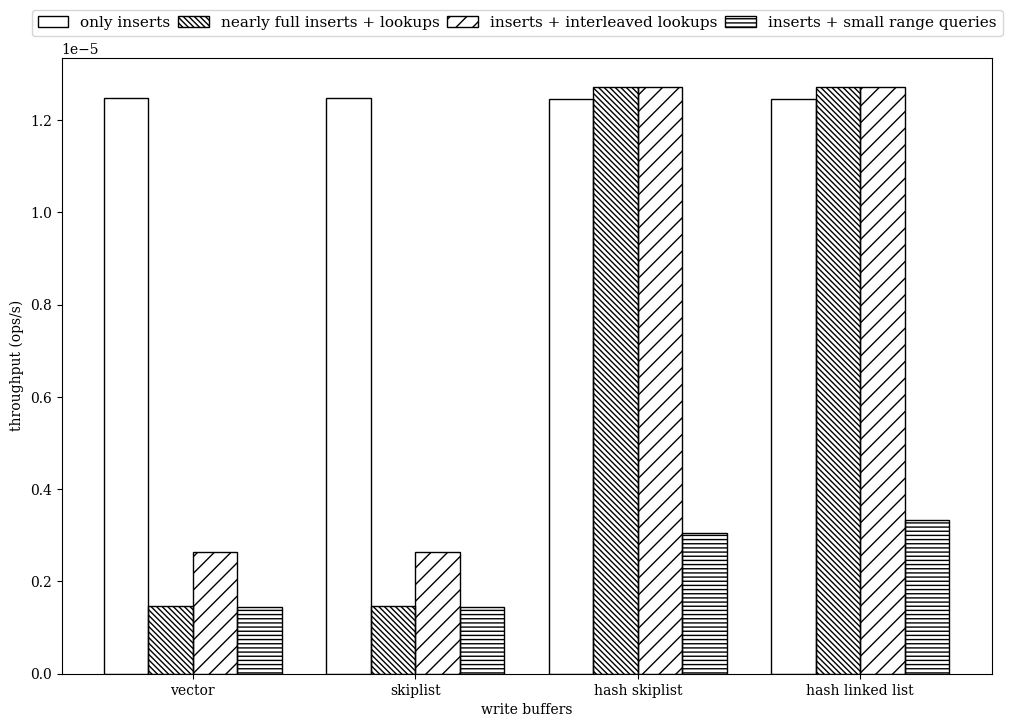

In [21]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(12, 8))

# compute the throughput for each workload and plot the bars for only inserts, nearly full, interleaved and small range queries
# print(vect_inserts, skip_inserts, hash_skip_inserts, hash_link_inserts)
width = 0.2

only_inserts_x_positions = [0-0.3, 0-0.1, 0+0.1, 0+0.3]
pre_allocated_vector = [1-0.3, 1-0.1, 1+0.1, 1+0.3]
# nearly_full_x_positions = [1-0.3, 1-0.1, 1+0.1, 1+0.3]

ax.bar(
    only_inserts_x_positions,
    [vect_inserts, vect_nearly_full_inserts, vect_interleaved_inserts, vect_small_inserts],
    color=["None", "None", "None", "None"],
    width=width,
    edgecolor=[edgecolor.get("Vector"), edgecolor.get("Skiplist"), edgecolor.get("Hashskiplist"), edgecolor.get("Hashlinklist")],
    hatch=[hatch.get("Vector"), hatch.get("Skiplist"), hatch.get("Hashskiplist"), hatch.get("Hashlinklist")],
    # alpha=[alpha.get("Vector"), alpha.get("Skiplist"), alpha.get("Hashskiplist"), alpha.get("Hashlinklist")],
    label="Vector",
)

ax.bar(
    pre_allocated_vector,
    [vector_pre_allocated, vect_nearly_full_inserts_pre_allocated, vect_interleaved_inserts_pre_allocated, vect_small_inserts_pre_allocated],
    color=["None", "None", "None", "None"],
    width=width,
    edgecolor=[edgecolor.get("Vector"), edgecolor.get("Skiplist"), edgecolor.get("Hashskiplist"), edgecolor.get("Hashlinklist")],
    hatch=[hatch.get("Vector"), hatch.get("Skiplist"), hatch.get("Hashskiplist"), hatch.get("Hashlinklist")],
    # alpha=[alpha.get("Vector"), alpha.get("Skiplist"), alpha.get("Hashskiplist"), alpha.get("Hashlinklist")],
    label="skip list",
)


# ax.bar(
#     nearly_full_x_positions,
#     [skip_inserts, skip_nearly_full_inserts, skip_interleaved_inserts, skip_small_inserts],
#     color=["None", "None", "None", "None"],
#     width=width,
#     edgecolor=[edgecolor.get("Vector"), edgecolor.get("Skiplist"), edgecolor.get("Hashskiplist"), edgecolor.get("Hashlinklist")],
#     hatch=[hatch.get("Vector"), hatch.get("Skiplist"), hatch.get("Hashskiplist"), hatch.get("Hashlinklist")],
#     # alpha=[alpha.get("Vector"), alpha.get("Skiplist"), alpha.get("Hashskiplist"), alpha.get("Hashlinklist")],
#     label="skip list",
# )

interleaved_x_positions = [2-0.3, 2-0.1, 2+0.1, 2+0.3]

ax.bar(
    interleaved_x_positions,
    [hash_skip_inserts, hash_skip_nearly_full_inserts, hash_skip_interleaved_inserts, hash_skip_small_inserts],
    color=["None", "None", "None", "None"],
    width=width,
    edgecolor=[edgecolor.get("Vector"), edgecolor.get("Skiplist"), edgecolor.get("Hashskiplist"), edgecolor.get("Hashlinklist")],
    hatch=[hatch.get("Vector"), hatch.get("Skiplist"), hatch.get("Hashskiplist"), hatch.get("Hashlinklist")],
    # alpha=[alpha.get("Vector"), alpha.get("Skiplist"), alpha.get("Hashskiplist"), alpha.get("Hashlinklist")],
    label="hash skip list",
)

small_range_x_positions = [3-0.3, 3-0.1, 3+0.1, 3+0.3]

ax.bar(
    small_range_x_positions,
    [hash_link_inserts, hash_link_nearly_full_inserts, hash_link_interleaved_inserts, hash_link_small_inserts],
    color=["None", "None", "None", "None"],
    width=width,
    edgecolor=[edgecolor.get("Vector"), edgecolor.get("Skiplist"), edgecolor.get("Hashskiplist"), edgecolor.get("Hashlinklist")],
    hatch=[hatch.get("Vector"), hatch.get("Skiplist"), hatch.get("Hashskiplist"), hatch.get("Hashlinklist")],
    # alpha=[alpha.get("Vector"), alpha.get("Skiplist"), alpha.get("Hashskiplist"), alpha.get("Hashlinklist")],
    label="Small Range",
)

legend_handles = [
    Patch(facecolor='white', edgecolor=edgecolor.get("Vector"), hatch=hatch.get("Vector"), label='only inserts'),
    Patch(facecolor='white', edgecolor=edgecolor.get("Skiplist"), hatch=hatch.get("Skiplist"), label='nearly full inserts + lookups'),
    Patch(facecolor='white', edgecolor=edgecolor.get("Hashskiplist"), hatch=hatch.get("Hashskiplist"), label='inserts + interleaved lookups'),
    Patch(facecolor='white', edgecolor=edgecolor.get("Hashlinklist"), hatch=hatch.get("Hashlinklist"), label='inserts + small range queries')
]

ax.legend(handles=legend_handles, loc='upper right', ncol=4, fontsize=11, bbox_to_anchor=(1.02, 1.09), columnspacing=0.5)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([
    "vector",
    "skiplist",
    "hash skiplist",
    "hash linked list"
])

ax.set_ylabel("throughput (ops/s)")
ax.set_xlabel("write buffers")

# ax.set_ylim(bottom=10**1)
# ax.set_yscale("log")

fig.savefig("throughput.eps", format="eps", bbox_inches="tight")

In [17]:
vect_inserts

1.2469378761427613e-05